<a href="https://colab.research.google.com/github/nemanja1995/Deep-Learning/blob/master/Visualizing-CNN/Visualizing_heatmaps_of_class_activation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import keras
keras.__version__
import matplotlib.pyplot as plt
import numpy as np
from keras.applications import VGG16
from keras.applications.vgg16 import VGG16
from keras import backend as K

from keras.preprocessing import image
from keras.applications.vgg16 import preprocess_input, decode_predictions
import cv2

img_path = 'dog.jpg'

Using TensorFlow backend.


## Visualizing heatmaps of class activation

We will introduce one more visualization technique, one that is useful for understanding which parts of a given image led a convnet to its 
final classification decision. This is helpful for "debugging" the decision process of a convnet, in particular in case of a classification 
mistake. It also allows you to locate specific objects in an image.

This general category of techniques is called "Class Activation Map" (CAM) visualization, and consists in producing heatmaps of "class 
activation" over input images. A "class activation" heatmap is a 2D grid of scores associated with an specific output class, computed for 
every location in any input image, indicating how important each location is with respect to the class considered. For instance, given a 
image fed into one of our "cat vs. dog" convnet, Class Activation Map visualization allows us to generate a heatmap for the class "cat", 
indicating how cat-like different parts of the image are, and likewise for the class "dog", indicating how dog-like differents parts of the 
image are.

The specific implementation we will use is the one described in [Grad-CAM: Why did you say that? Visual Explanations from Deep Networks via 
Gradient-based Localization](https://arxiv.org/abs/1610.02391). It is very simple: it consists in taking the output feature map of a 
convolution layer given an input image, and weighing every channel in that feature map by the gradient of the class with respect to the 
channel. Intuitively, one way to understand this trick is that we are weighting a spatial map of "how intensely the input image activates 
different channels" by "how important each channel is with regard to the class", resulting in a spatial map of "how intensely the input 
image activates the class".

We will demonstrate this technique using the pre-trained VGG16 network again:

In [2]:
K.clear_session()

# Note that we are including the densely-connected classifier on top;
# all previous times, we were discarding it.
model = VGG16(weights='imagenet')

Instructions for updating:
Colocations handled automatically by placer.


Let's convert this image into something the VGG16 model can read: the model was trained on images of size 224x244, preprocessed according 
to a few rules that are packaged in the utility function `keras.applications.vgg16.preprocess_input`. So we need to load the image, resize 
it to 224x224, convert it to a Numpy float32 tensor, and apply these pre-processing rules.

In [0]:
# `img` is a PIL image of size 224x224
img = image.load_img(img_path, target_size=(224, 224))

# `x` is a float32 Numpy array of shape (224, 224, 3)
x = image.img_to_array(img)

# We add a dimension to transform our array into a "batch"
# of size (1, 224, 224, 3)
x = np.expand_dims(x, axis=0)

# Finally we preprocess the batch
# (this does channel-wise color normali"zation)
x = preprocess_input(x)

In [4]:
preds = model.predict(x)
predictions = decode_predictions(preds, top=3)[0]
print('Predicted:')
print('1.', predictions[0][1],'[',str(predictions[0][2]*100),'%]')
print('2.', predictions[1][1],'[',str(predictions[1][2]*100),'%]')
print('3.', predictions[2][1],'[',str(predictions[2][2]*100),'%]')


40960/35363 [==================================] - 0s 2us/step
Predicted:
1. malamute [ 42.49974489212036 %]
2. Eskimo_dog [ 34.356674551963806 %]
3. Siberian_husky [ 22.95253276824951 %]


In [0]:
# This is the entry in the prediction vector
network_output = model.output[:, np.argmax(preds[0])]

# The is the output feature map of the `block5_conv3` layer,
# the last convolutional layer in VGG16
last_conv_layer = model.get_layer('block5_conv3')

# This is the gradient of the class with regard to
# the output feature map of `block5_conv3`
grads = K.gradients(network_output, last_conv_layer.output)[0]

# This is a vector of shape (512,), where each entry
# is the mean intensity of the gradient over a specific feature map channel
pooled_grads = K.mean(grads, axis=(0, 1, 2))

# This function allows us to access the values of the quantities we just defined:
# `pooled_grads` and the output feature map of `block5_conv3`,
# given a sample image
iterate = K.function([model.input], [pooled_grads, last_conv_layer.output[0]])

# These are the values of these two quantities, as Numpy arrays,
# given our sample image of two elephants
pooled_grads_value, conv_layer_output_value = iterate([x])

# We multiply each channel in the feature map array
# by "how important this channel is" with regard to the elephant class
for i in range(512):
    conv_layer_output_value[:, :, i] *= pooled_grads_value[i]

# The channel-wise mean of the resulting feature map
# is our heatmap of class activation
heatmap = np.mean(conv_layer_output_value, axis=-1)

For visualization purpose, we will also normalize the heatmap between 0 and 1:

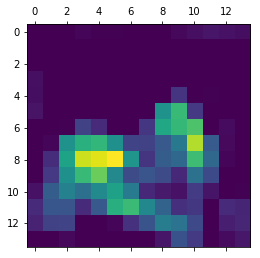

In [6]:
heatmap = np.maximum(heatmap, 0)
heatmap /= np.max(heatmap)
plt.matshow(heatmap)
plt.show()

Finally, we will use OpenCV to generate an image that superimposes the original image with the heatmap we just obtained:

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


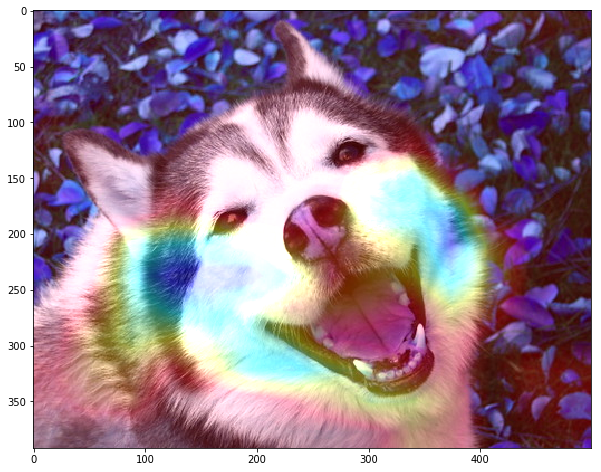

In [7]:
cam_img_path = 'cam_'+img_path

# We use cv2 to load the original image
img = cv2.imread(img_path)

# We resize the heatmap to have the same size as the original image
heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))

# We convert the heatmap to RGB
heatmap = np.uint8(255 * heatmap)

# We apply the heatmap to the original image
heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)

# 0.4 here is a heatmap intensity factor
superimposed_img = heatmap * 0.4 + img

# Save the image to disk
cv2.imwrite(cam_img_path, superimposed_img)

img = image.load_img(cam_img_path, target_size=(224, 224))
img_tensor = image.img_to_array(img)
img_tensor = np.expand_dims(img_tensor, axis=0)
# Remember that the model was trained on inputs
# that were preprocessed in the following way:
img_tensor /= 255.

plt.figure(figsize=(10,10))
plt.imshow(superimposed_img/255)
plt.show()